In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
from vnstock import Vnstock
import time

def connect(host, user, database, password):
    """Establishes a connection to the SQL database."""
    engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')
    connection = engine.connect()
    print("Connection successful!")
    return connection


def get_data(query):
    try:
        # Establish connection
        engine = connect('localhost', 'root', 'STOCK', 'Eninoskybaby94$')
        # Define your SQL query
        df = pd.read_sql(query, con=engine)
        # Close the connection
        engine.close()
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
def cash_flow(all_symbols):
        # Connect to the database
        #engine = connect('localhost', 'root', 'STOCK', 'Eninoskybaby94$')
        # Fetch all symbols from the database
        # Fetch cash flow data for each symbol
        # Initialize an empty list to store DataFrames
        data =[]
        try:
            # Loop through each symbol and fetch data
            for symbol in all_symbols:
                df_cashflow = Vnstock(show_log=False).stock(symbol=symbol, source='VCI').finance.cash_flow(period='year', dropna=True)
                time.sleep(2)
                data.append(df_cashflow)
            CF = pd.concat(data) 
            print("Data inserted successfully into the Cash_flow table.")
        except Exception as e:
            print(f"An error occurred while fetching data for {symbol}: {e}")
            pass
        return CF
        # Close the connection
        #engine.close()
def company_profile(all_symbols):
        # Connect to the database
        engine = connect('localhost', 'root', 'STOCK', 'Eninoskybaby94$')
        data =[]
        for symbol in all_symbols:
            try:
                company = Vnstock(show_log=False).stock(symbol=symbol, source='TCBS').company.overview()
                company =company.iloc[:, [0,2,5,7]]
                data.append(company)
            except Exception:
                    pass
            time.sleep(1)
        df = pd.concat(data)
        df.to_sql('Company_profile', con=engine, if_exists='replace', index=False)
        print("Data inserted successfully into the Company_profile table.")

In [2]:
liquidity = get_data('SELECT * FROM Volume')
# Display the first few rows of the DataFrame
print(liquidity.head())

Connection successful!
  symbol  volume
0    S55     452
1    VC3    2400
2    SJD   29585
3    SFI    1100
4    PAC   24010


* Bước 1: Lọc cổ phiếu

In [3]:
FR = get_data('SELECT * FROM view_finance_ratio')
FR

Connection successful!


,Symbol,Quarter,P/E,P/B,EPS
0,YEG,3/2024,25.499419,1.330258,190.329723
1,YEG,2/2024,23.592810,0.931462,87.290017
2,YEG,1/2024,25.099016,0.976986,125.372469
3,YEG,4/2023,34.266406,0.881381,112.734684
4,YEG,3/2023,52.291539,1.038022,46.646016
...,...,...,...,...,...
29656,AAA,1/2014,7.408135,0.695347,740.557827
29657,AAA,4/2013,7.749043,0.783334,575.334411
29658,AAA,3/2013,6.025149,0.772142,666.123702
29659,AAA,2/2013,4.033581,0.596731,663.724346


In [4]:
# Get the data from the SQL database 
RT = get_data('Select * from Stock_returns_12_23')
RT.head(10)

Connection successful!


,Symbol,TIME,daily_return
0,AAA,2012-01-03,0.015326
1,AAA,2012-01-04,0.018868
2,AAA,2012-01-05,-0.007407
3,AAA,2012-01-06,-0.018657
4,AAA,2012-01-09,0.019011
5,AAA,2012-01-10,0.048507
6,AAA,2012-01-11,-0.014235
7,AAA,2012-01-12,-0.007220
8,AAA,2012-01-13,0.007273
9,AAA,2012-01-16,0.025271


In [5]:
import numpy as np
# Calculate daily returns
RT

,Symbol,TIME,daily_return
0,AAA,2012-01-03,0.015326
1,AAA,2012-01-04,0.018868
2,AAA,2012-01-05,-0.007407
3,AAA,2012-01-06,-0.018657
4,AAA,2012-01-09,0.019011
...,...,...,...
963937,YEG,2023-12-25,0.004348
963938,YEG,2023-12-26,-0.038961
963939,YEG,2023-12-27,0.013514
963940,YEG,2023-12-28,0.066667


In [6]:
from scipy.stats import trim_mean

tickers = RT['Symbol'].unique()

def get_stock_data(ticker,TRIM_PROPORTION):
    try:
        # Lấy dữ liệu lịch sử
        daily_returns = RT[RT['Symbol'] == ticker]['daily_return']
        daily_volume  = liquidity[liquidity['symbol'] == ticker]['volume']
        # Tính trimmed mean daily return
        trimmed_mean_return = trim_mean(daily_returns, proportiontocut=TRIM_PROPORTION)
        trimmed_mean_volume  = trim_mean(daily_volume, proportiontocut=TRIM_PROPORTION)
        
        # Độ lệch chuẩn của daily return
        std_daily_return = daily_returns.std()
        std_daily_volume = daily_volume.std()
        
        # Tính Coefficient of Variation (CV)
        cv_return = std_daily_return / trimmed_mean_return if trimmed_mean_return != 0 else float('inf')
        cv_colume = std_daily_volume / trimmed_mean_volume if trimmed_mean_volume != 0 else float('inf')       
               
        return {
            'Ticker': ticker,
            'CV_return': cv_return,
            'Cv_colume': cv_colume,
            }
    except Exception as e:
        print(f"Error with {ticker}: {e}")
        return None

# Lấy dữ liệu cho tất cả cổ phiếu
data = []
for ticker in tickers:
    result = get_stock_data(ticker,0.1)
    if result:
        data.append(result)

# Chuyển sang DataFrame
df = pd.DataFrame(data)
df

,Ticker,CV_return,Cv_colume
0,AAA,45.307781,1.791530
1,AAM,82.203985,5.332479
2,AAT,-23.437304,0.922427
3,ABR,38.879853,8.558336
4,ABS,113.617088,1.697842
...,...,...,...
385,VTB,20.346879,5.866578
386,VTO,56.486457,2.210871
387,VTP,82.625558,1.769495
388,YBM,-133.209569,5.166161


In [7]:
df_grouped = RT.groupby('Symbol').agg({
                            'daily_return': ['mean', 'std'],})
df_grouped.columns = ['mean_return', 'std_return']
df_grouped = df_grouped.reset_index()
df_grouped['CV_return'] = df_grouped['std_return'] / df_grouped['mean_return']
df_grouped_RT= df_grouped[(df_grouped['CV_return']>0)].sort_values(by='CV_return', ascending=True, inplace=False)  
df_grouped_RT.describe()

,mean_return,std_return,CV_return
count,364.000000,364.000000,364.000000
mean,0.000894,0.026963,58.159182
std,0.000404,0.006416,200.234173
min,0.000011,0.012900,10.916788
25%,0.000660,0.022586,22.834196
50%,0.000872,0.026199,29.492282
75%,0.001098,0.030565,40.081630
max,0.002682,0.058310,2975.266071


In [8]:
VL = get_data('SELECT * FROM Volume')


Connection successful!


In [9]:
df_grouped = VL.groupby('symbol').agg({
                            'volume': ['mean', 'std'],})
df_grouped.columns = ['mean_volume', 'std_volume']
df_grouped = df_grouped.reset_index()
df_grouped['CV_volume'] = df_grouped['std_volume'] / df_grouped['mean_volume']
df_grouped_VL=df_grouped[(df_grouped['CV_volume']>0)].sort_values(by='CV_volume', ascending=True, inplace=False)  
df_grouped_VL.describe()

,mean_volume,std_volume,CV_volume
count,7.030000e+02,7.030000e+02,703.000000
mean,4.988202e+05,6.593534e+05,2.835194
std,1.216338e+06,1.553388e+06,2.841121
min,1.177336e+00,1.207842e+01,0.480185
25%,5.715483e+03,1.912971e+04,1.405491
50%,5.220767e+04,1.062680e+05,2.026525
75%,3.522348e+05,4.717397e+05,3.112704
max,9.002053e+06,1.252290e+07,29.063419


In [10]:
df_merge = pd.merge(df_grouped_RT, df_grouped_VL, left_on='Symbol', right_on='symbol', how='inner')
threshold = df_merge.describe()[['CV_return', 'CV_volume']]
threshold

,CV_return,CV_volume
count,364.000000,364.000000
mean,58.159182,2.087935
std,200.234173,1.845029
min,10.916788,0.480185
25%,22.834196,1.258972
50%,29.492282,1.643266
75%,40.081630,2.297825
max,2975.266071,19.605718


In [11]:
df= df_merge 
conditions_rt = [df['CV_return'] <= threshold.loc['25%','CV_return'], df['CV_return'] >=threshold.loc['75%','CV_return'] ]
choices_rt = ['low', 'high']
df['Return_risk'] = np.select(conditions_rt, choices_rt, default='moderate')

conditions_vl = [df['CV_volume'] <= threshold.loc['25%','CV_volume'], df['CV_volume'] >=threshold.loc['75%','CV_volume'] ]
choices_vl = ['low', 'high']
df['Volume_risk'] = np.select(conditions_rt, choices_rt, default='moderate')

In [12]:
df['Return_risk'].value_counts().reset_index()

,Return_risk,count
0,moderate,182
1,low,91
2,high,91


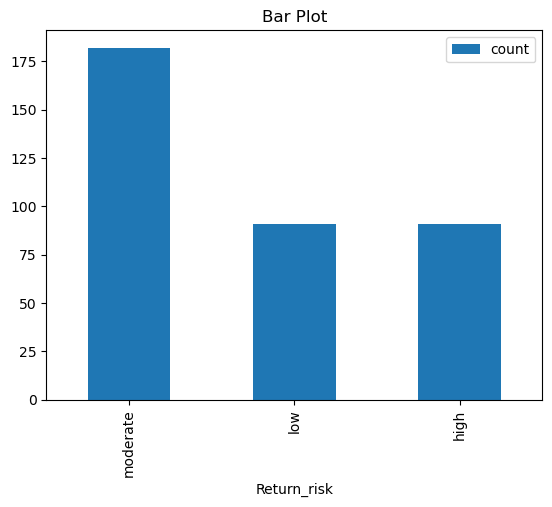

In [13]:
import matplotlib.pyplot as plt
df['Return_risk'].value_counts().reset_index().plot(x='Return_risk', y='count', kind='bar', title='Bar Plot')
plt.show()

In [14]:
df[['Symbol','mean_return','mean_volume','Return_risk','Volume_risk']]

,Symbol,mean_return,mean_volume,Return_risk,Volume_risk
0,FIR,0.001498,2.014381e+05,low,low
1,SIP,0.002682,7.046648e+04,low,low
2,TV2,0.001934,7.174564e+04,low,low
3,SBA,0.001103,4.238779e+04,low,low
4,SSB,0.001236,1.592629e+06,low,low
...,...,...,...,...,...
359,VRE,0.000075,3.531141e+06,high,high
360,LEC,0.000100,2.204318e+03,high,high
361,SPM,0.000030,4.229613e+03,high,high
362,TLD,0.000014,4.783530e+05,high,high


In [15]:
market_cap_weighted_return = get_data('SELECT * FROM market_cap_weighted_return')
market_cap_weighted_return.sort_values(by='market_cap_percent', ascending=False, inplace=False)

Connection successful!


,symbol,industry,market_cap_percent
36,VCB,Ngân hàng,9.679286
337,BID,Ngân hàng,4.918224
257,FPT,Công nghệ Thông tin,4.260089
304,CTG,Ngân hàng,3.854541
81,TCB,Ngân hàng,3.306965
...,...,...,...
240,HAS,Xây dựng và Vật liệu,0.001185
353,AGM,Thực phẩm và đồ uống,0.001147
214,HU1,Xây dựng và Vật liệu,0.001044
269,DXV,Xây dựng và Vật liệu,0.000714


In [16]:
df_merge = pd.merge(df, market_cap_weighted_return, left_on='Symbol', right_on='symbol', how='inner')
df_merge= df_merge[['Symbol','industry','mean_return','mean_volume','Return_risk','Volume_risk','market_cap_percent']].sort_values(by='market_cap_percent', ascending=False, inplace=False)

In [17]:
df_merge

,Symbol,industry,mean_return,mean_volume,Return_risk,Volume_risk,market_cap_percent
47,VCB,Ngân hàng,0.000972,1.062110e+06,low,low,9.679286
143,BID,Ngân hàng,0.000854,1.850575e+06,moderate,moderate,4.918224
6,FPT,Công nghệ Thông tin,0.001072,1.178608e+06,low,low,4.260089
184,CTG,Ngân hàng,0.000696,3.905220e+06,moderate,moderate,3.854541
322,TCB,Ngân hàng,0.000181,6.491993e+06,high,high,3.306965
...,...,...,...,...,...,...,...
262,HAS,Xây dựng và Vật liệu,0.000730,8.115067e+03,high,high,0.001185
323,AGM,Thực phẩm và đồ uống,0.000227,5.105205e+04,high,high,0.001147
239,HU1,Xây dựng và Vật liệu,0.000903,7.353697e+03,moderate,moderate,0.001044
280,DXV,Xây dựng và Vật liệu,0.000662,1.573200e+04,high,high,0.000714


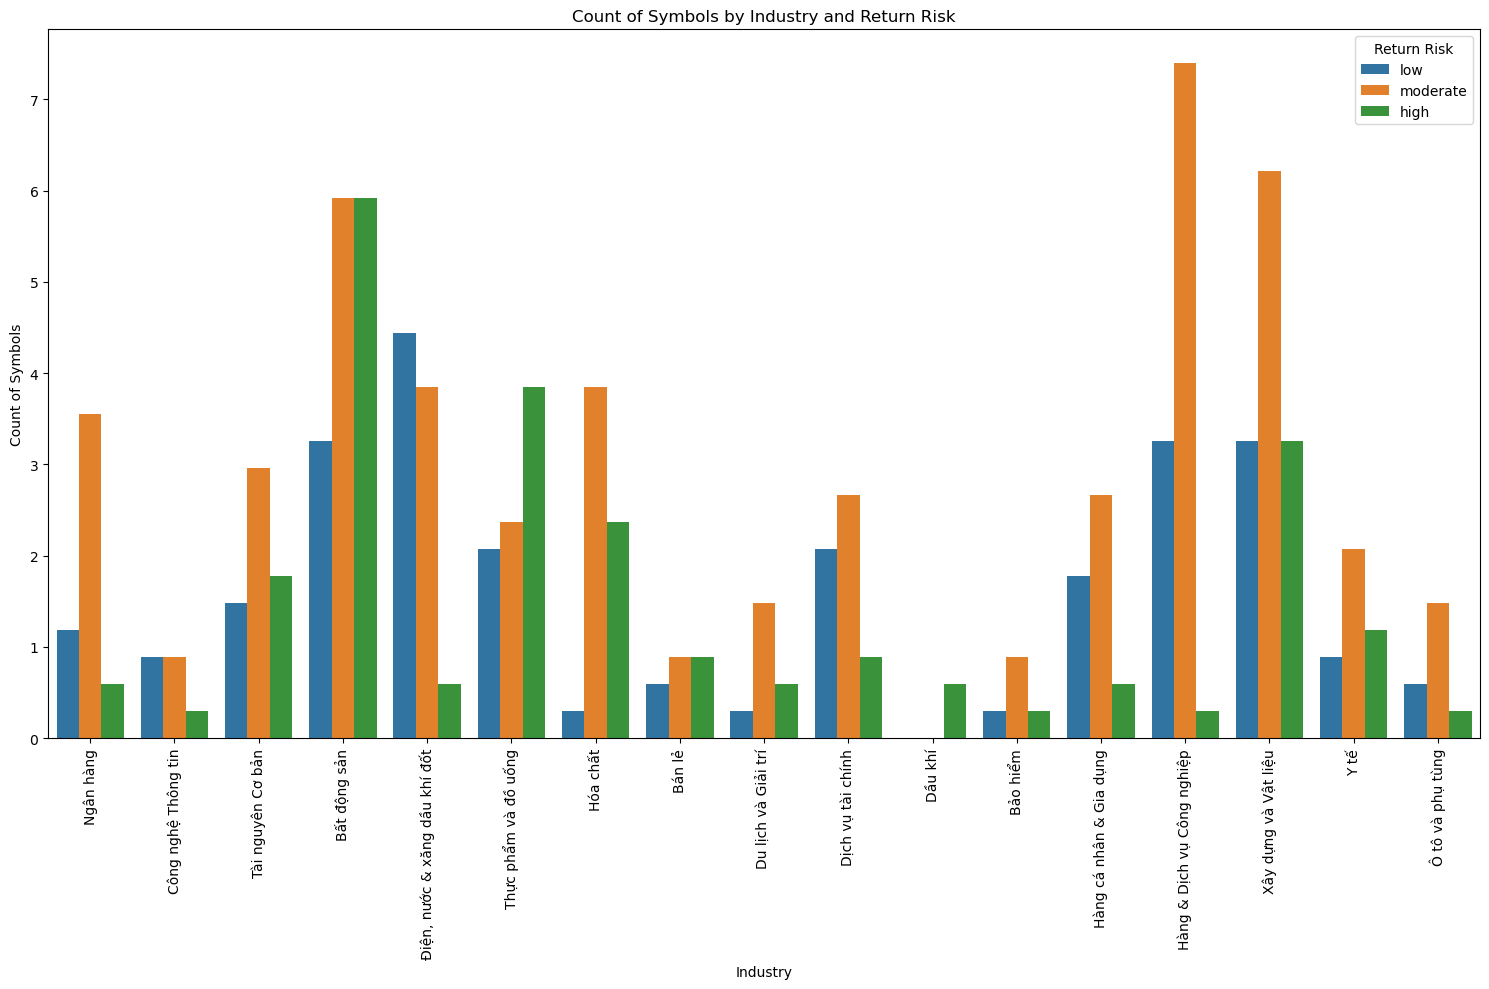

In [18]:
import seaborn as sns
data = df_merge
plt.figure(figsize=(15, 10))
sns.countplot(data, x="industry", hue="Return_risk",stat="percent")
plt.title('Count of Symbols by Industry and Return Risk')
plt.xlabel('Industry')
plt.ylabel('Count of Symbols')
plt.legend(title='Return Risk')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Stacked Bar Plot'}, xlabel='industry'>

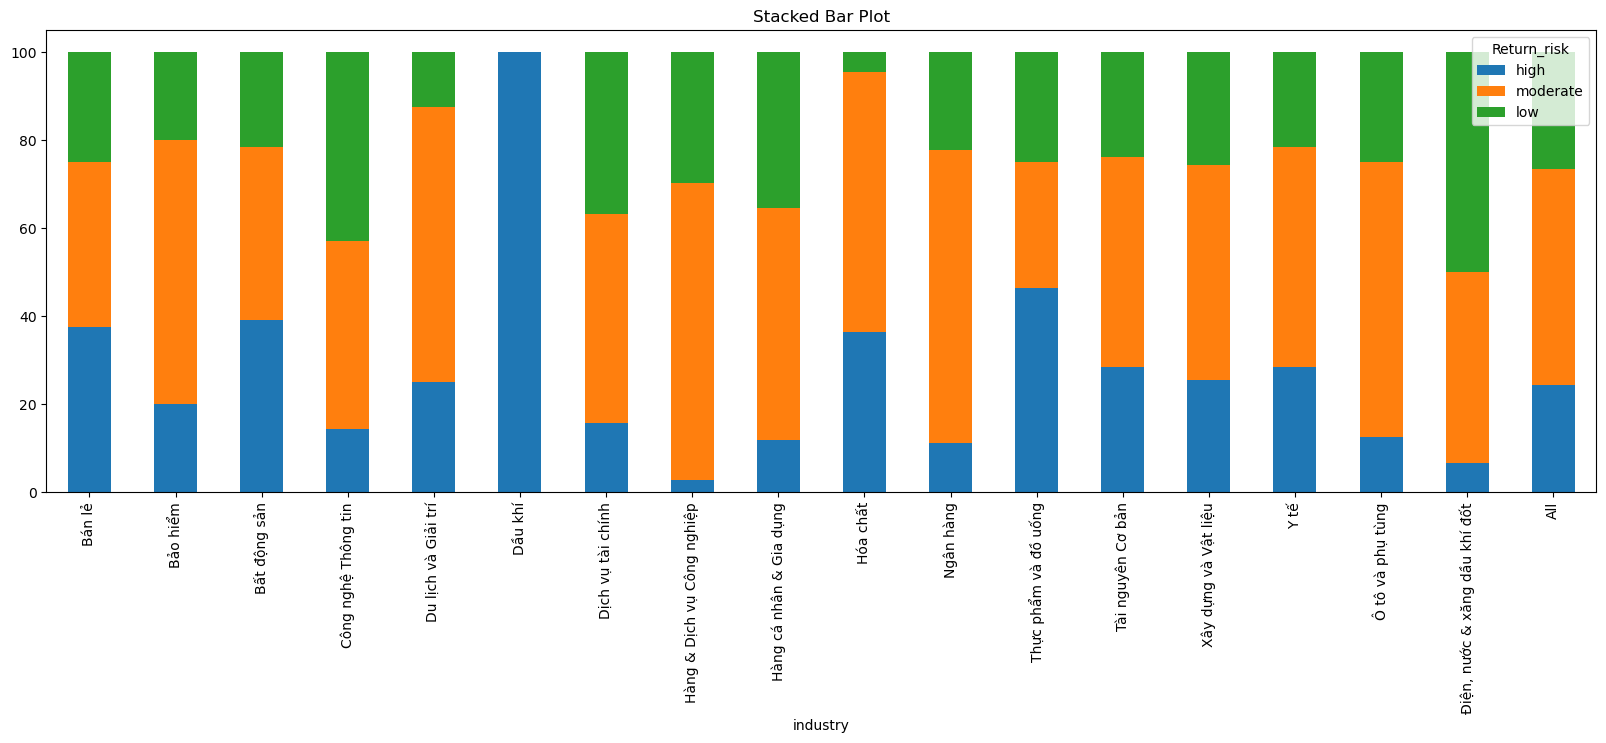

In [19]:
crossbar = pd.crosstab(df_merge['industry'], df_merge['Return_risk'],margins=True)
crossbar['high'] = crossbar['high'] / crossbar['All'] * 100
crossbar['moderate'] = crossbar['moderate'] / crossbar['All'] * 100
crossbar['low'] = crossbar['low'] / crossbar['All'] * 100
crossbar= crossbar[['high', 'moderate', 'low']]
crossbar.plot(kind='bar', stacked=True, title='Stacked Bar Plot',figsize=(20, 6))


In [20]:
import pandas as pd
from scipy.stats import chi2_contingency

# Prepare the contingency table
contingency_table = pd.crosstab(df_merge['industry'], df_merge['Return_risk'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display the results
print("Chi-Square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-Value:", p)

# Interpret the results
if p < 0.05:
    print("There is a significant relationship between rate of return and industry.")
else:
    print("There is no significant relationship between rate of return and industry.")

Chi-Square Statistic: 56.08610280413603
Degrees of Freedom: 32
P-Value: 0.005310856746813941
There is a significant relationship between rate of return and industry.


In [21]:
contingency_table

Return_risk,high,low,moderate
industry,,,
Bán lẻ,3,2,3
Bảo hiểm,1,1,3
Bất động sản,20,11,20
Công nghệ Thông tin,1,3,3
Du lịch và Giải trí,2,1,5
Dầu khí,2,0,0
Dịch vụ tài chính,3,7,9
Hàng & Dịch vụ Công nghiệp,1,11,25
Hàng cá nhân & Gia dụng,2,6,9


In [22]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [23]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Prepare the data for ANOVA
anova_data = df_merge[['industry', 'Volume_risk', 'mean_return']].dropna()
# Fit the two-way ANOVA model with replication
model = ols('mean_return ~ C(industry) + C(Volume_risk) + C(industry):C(Volume_risk)', data=anova_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA table
print(anova_table)

# Interpret the results
if anova_table['PR(>F)']['C(industry):C(Volume_risk)'] < 0.05:
    print("There is a significant interaction effect between industry and volume risk on mean return.")
else:
    print("There is no significant interaction effect between industry and volume risk on mean return.")

                              sum_sq     df          F        PR(>F)
C(industry)                 0.000004   16.0   4.158615  1.225026e-06
C(Volume_risk)              0.000012    2.0  89.746469  4.821117e-31
C(industry):C(Volume_risk)  0.000002   32.0   1.066236  3.777632e-01
Residual                    0.000019  289.0        NaN           NaN
There is no significant interaction effect between industry and volume risk on mean return.


covariance of constraints does not have full rank. The number of constraints is 16, but rank is 14
covariance of constraints does not have full rank. The number of constraints is 32, but rank is 30


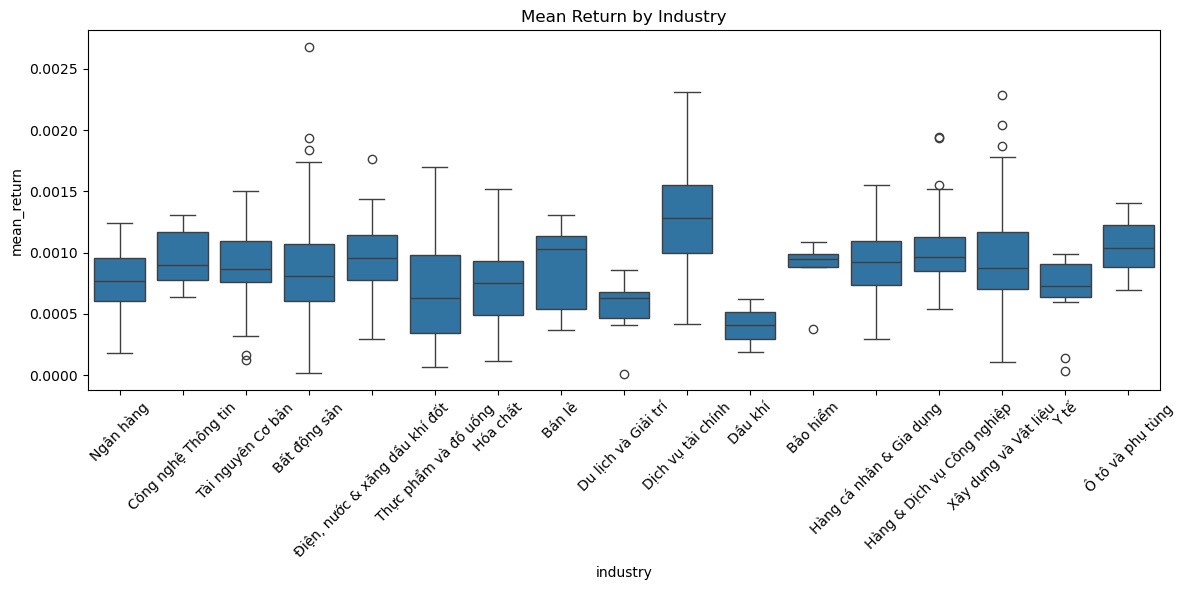

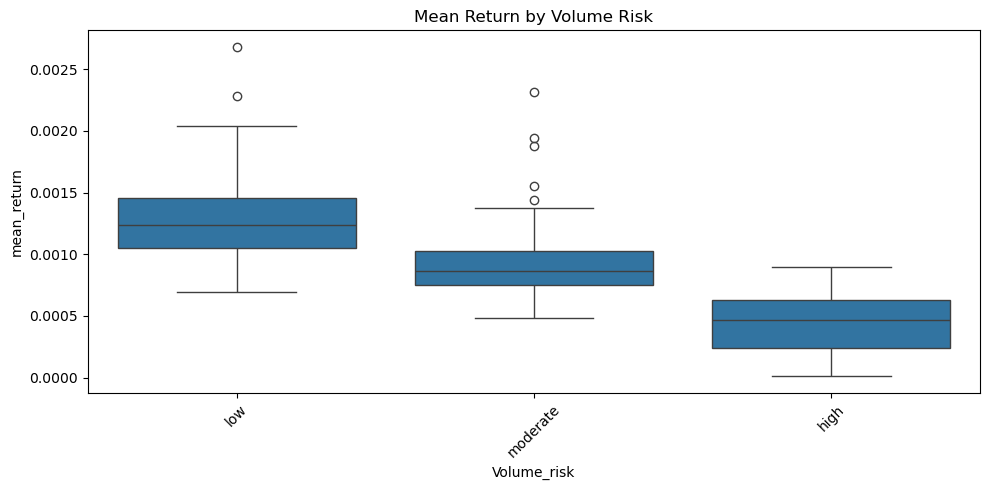

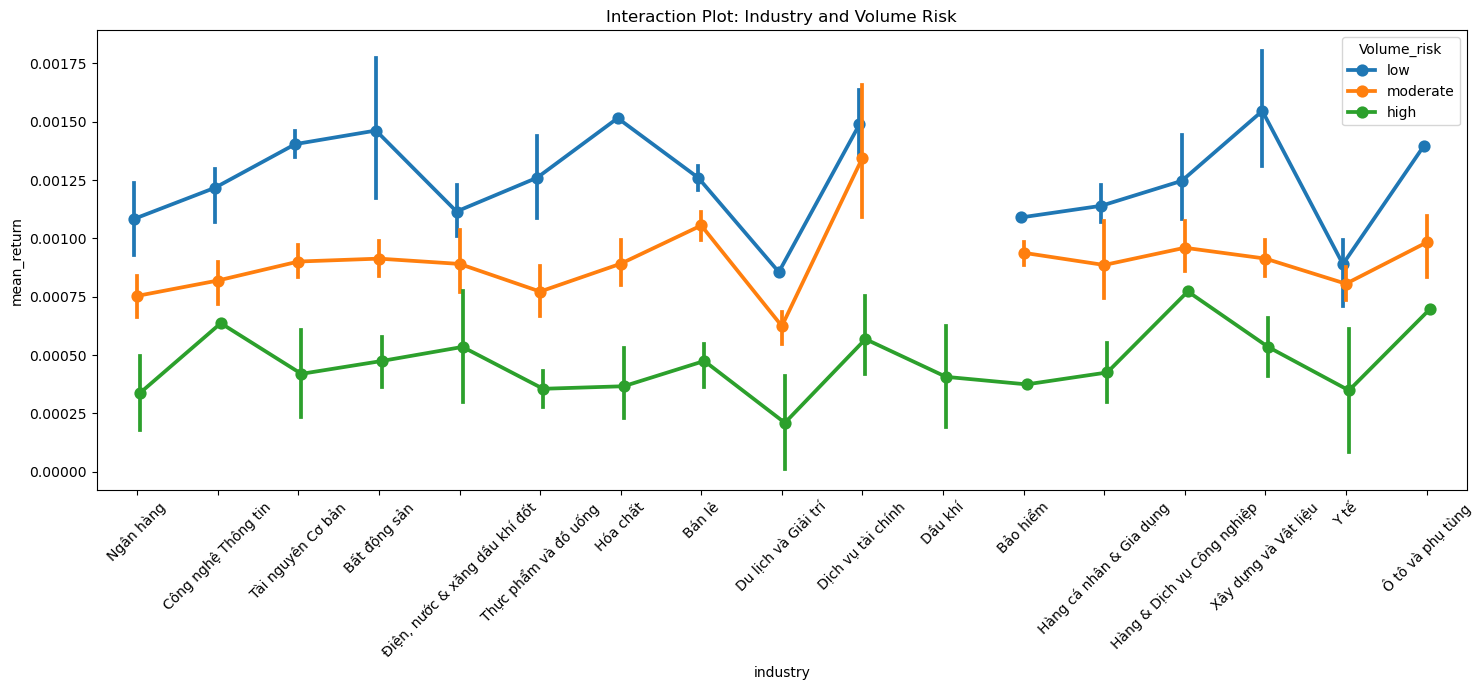

In [24]:
# Boxplot for Mean Return by Industry
plt.figure(figsize=(12, 6))  # Adjust the size for this subplot
sns.boxplot(x='industry', y='mean_return', data=anova_data)
plt.title('Mean Return by Industry')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot for Mean Return by Volume Risk
plt.figure(figsize=(10, 5))  # Adjust the size for this subplot
sns.boxplot(x='Volume_risk', y='mean_return', data=anova_data)
plt.title('Mean Return by Volume Risk')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Interaction Plot: Industry and Volume Risk
plt.figure(figsize=(15, 7))  # Adjust the size for this subplot
sns.pointplot(x='industry', y='mean_return', hue='Volume_risk', data=anova_data, dodge=True)
plt.title('Interaction Plot: Industry and Volume Risk')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
#3. Checking Assumptions
from scipy.stats import shapiro
#Normality: P-value > 0.05 suggests residuals are normally distributed.
# Get residuals from the model
residuals = model.resid
stat, p = shapiro(residuals)
print(f"Shapiro-Wilk Test for Normality: p-value = {p:.3f}")
if p > 0.05:
    print("Residuals are normally distributed.")
else:
    print("Residuals are not normally distributed.")


Shapiro-Wilk Test for Normality: p-value = 0.000
Residuals are not normally distributed.


In [26]:
# get data from database
FCF = get_data('SELECT * from  FCF')
FCF_grouped = FCF.sort_values(['industry','year'], ascending=[True, True]).groupby(['industry','year']).agg({'FCF': ['mean']}).reset_index()
FCF_grouped.columns = ['industry','year','mean_FCF']
FCF_grouped
FCF_grouped['growth'] = FCF_grouped.groupby('industry')['mean_FCF'].pct_change() *100
FCF_grouped = FCF_grouped[FCF_grouped['year'] > 2021].groupby('industry').agg({'growth': ['mean'], 'mean_FCF': ['mean']}).reset_index()
FCF_grouped.columns = ['industry','mean_growth','mean_FCF']
FCF_grouped

Connection successful!


,industry,mean_growth,mean_FCF
0,Bán lẻ,121.778445,4.017642e+12
1,Bất động sản,31.853775,1.025307e+13
2,Công nghệ Thông tin,22.850924,1.223145e+13
3,Du lịch và Giải trí,-25.202042,1.318254e+12
4,Dịch vụ tài chính,-592.818920,-3.838605e+12
5,Hàng & Dịch vụ Công nghiệp,40.274876,1.453018e+12
6,Hàng cá nhân & Gia dụng,245.745257,6.378745e+11
7,Hóa chất,-14.072130,3.123705e+12
8,Ngân hàng,80.671968,2.605540e+13
9,Thực phẩm và đồ uống,25.846627,3.708678e+12


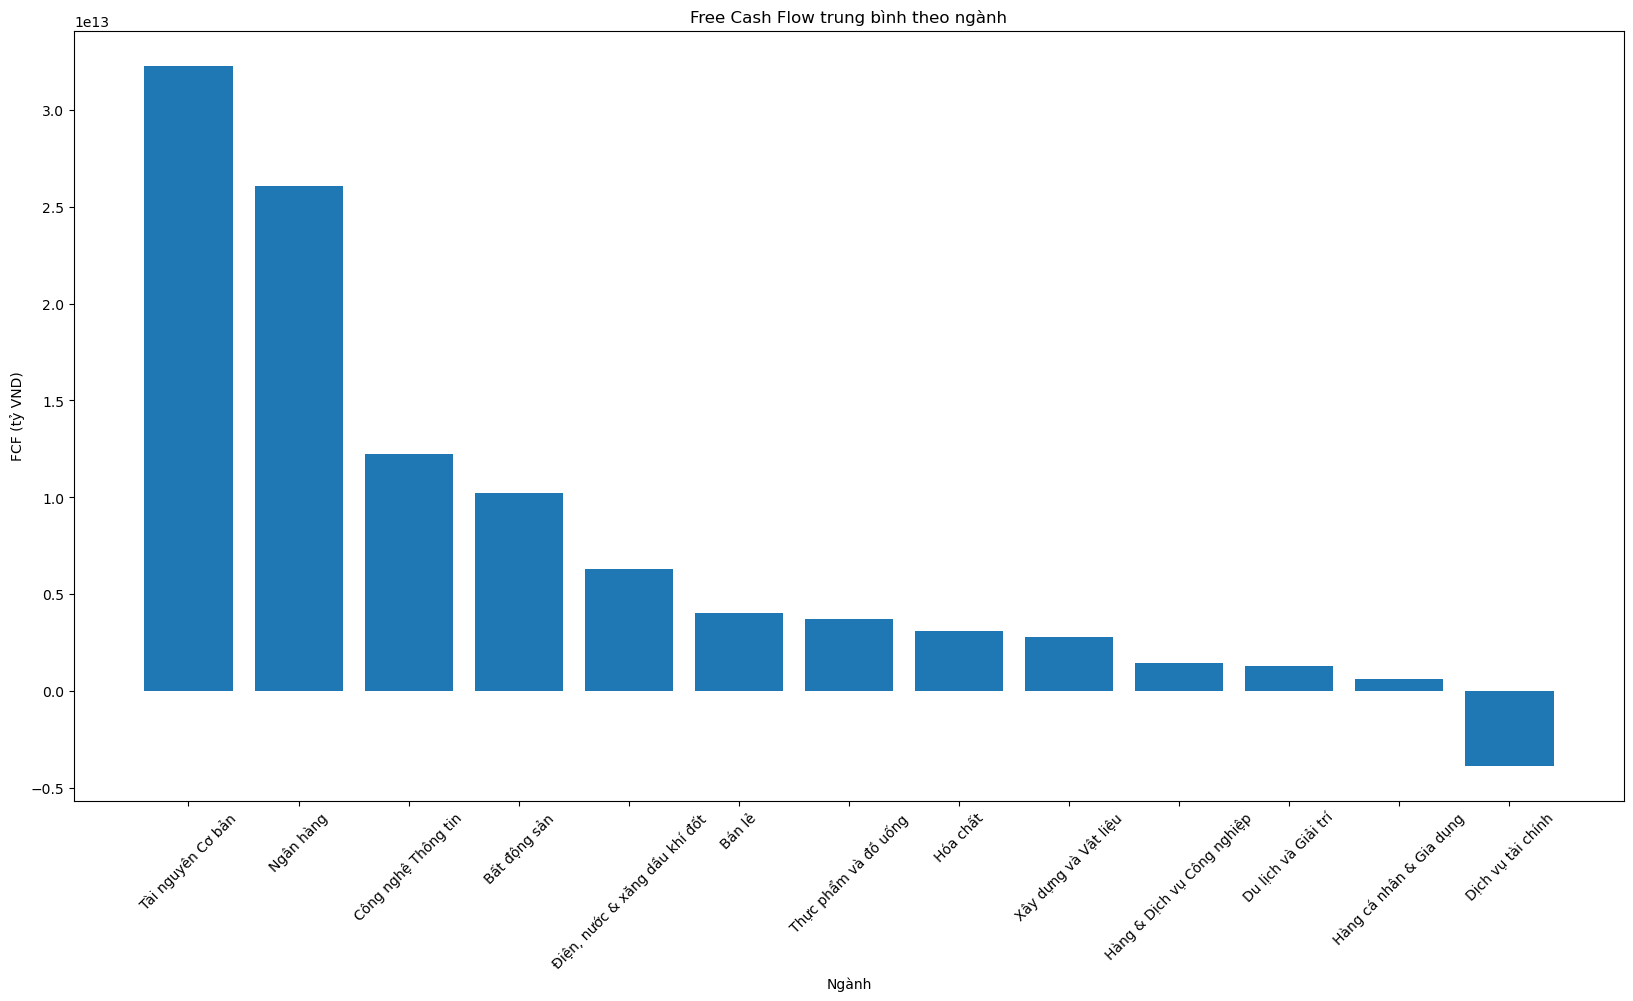

In [ ]:
# Trực quan hóa
df = FCF_grouped.sort_values(by='mean_FCF', ascending=False).head(20)
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.bar(df["industry"], df["mean_FCF"])
plt.title("Free Cash Flow trung bình theo ngành")
plt.xlabel("Ngành")
plt.ylabel("FCF (Nghin tỷ VND)")
plt.xticks(rotation=45)
plt.show()

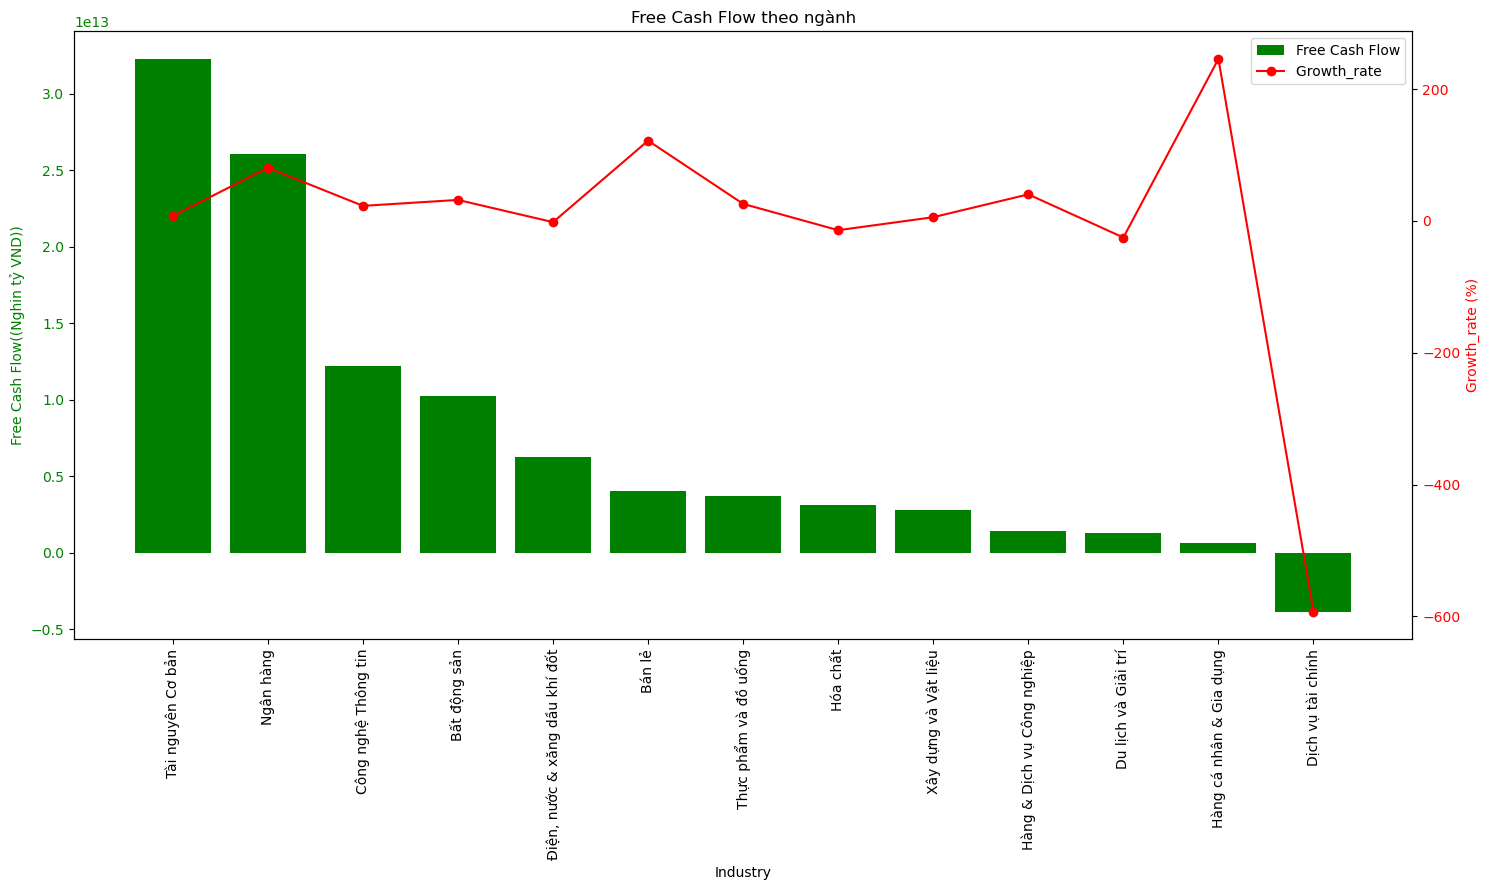

In [49]:

fig, ax1 = plt.subplots(figsize=(15, 9))

# Bar chart
bar_color = 'green'
ax1.bar(df['industry'], df['mean_FCF'], color=bar_color, label='Free Cash Flow')
ax1.set_xlabel('Industry')
ax1.set_ylabel('Free Cash Flow((Nghin tỷ VND))', color=bar_color)
ax1.tick_params('y', labelcolor=bar_color)

plt.xticks(rotation=90)

# Create a second y-axis for the line chart
line_color = 'red'
ax2 = ax1.twinx()
ax2.plot(df['industry'],df['mean_growth'] , color=line_color, marker='o', label='Growth_rate ')
ax2.set_ylabel('Growth_rate (%)', color=line_color)
ax2.tick_params('y', labelcolor=line_color)


# Title and legend
plt.title('Free Cash Flow theo ngành')
fig.tight_layout()

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')